Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz
Loading forward matrix: E2EForward_Nonlinear/RankSweep/Matrices/chestmnist\rank_025.pkl
Loading inverse matrix: E2EInverse_Nonlinear/RankSweep/Matrices/chestmnist\rank_025.pkl


C:\Users\alexr\AppData\Local\Temp\ipykernel_31668\180111731.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


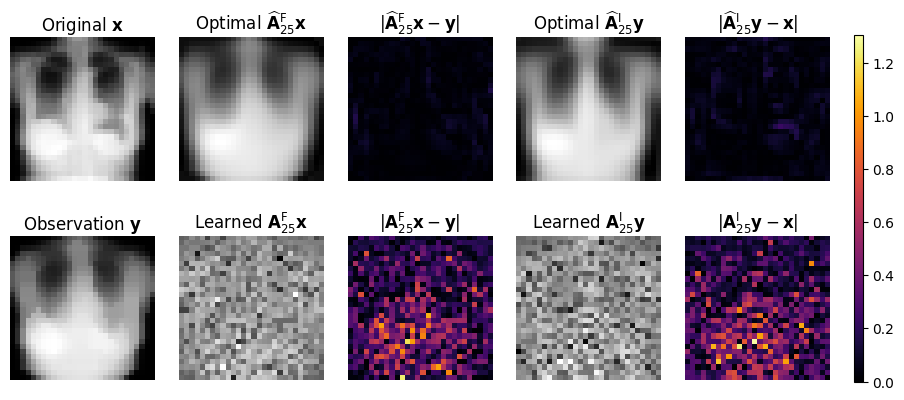

In [2]:
# ============================================================
# 2×6 Comparison Plot for Nonlinear (Median-Blur) Experiments
# Loads forward + inverse mapping matrices from saved .pkl files
# Stand-alone script — all variables defined inside
# ============================================================

import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import medmnist
from medmnist import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------------
# User settings
# ------------------------------------------------------------
data_flag = 'chestmnist'   # dataset to visualize
rank_r    = 25            # rank to visualize
idx       = 7181           # index to visualize
kernel_k  = 5              # median filter kernel


# ------------------------------------------------------------
# Helper: Load n MedMNIST images as tensor
# ------------------------------------------------------------
def load_medmnist_raw(data_flag, split='train'):
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    ds = DataClass(split=split, download=True)

    imgs = []
    for i in range(len(ds)):
        x, _ = ds[i]

        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)

        # we only need grayscale
        imgs.append(t[0])

    return torch.stack(imgs).to(device)


# ------------------------------------------------------------
# Helper: Nonlinear median blur operator
# ------------------------------------------------------------
def median_blur(x, k=5):
    if x.ndim == 2:
        x_in = x.unsqueeze(0)  # (1,H,W)
    elif x.ndim == 3:
        x_in = x
    else:
        raise ValueError("Input must be (H,W) or (C,H,W).")

    C, H, W = x_in.shape
    out = torch.zeros_like(x_in)

    for c in range(C):
        patches = F.unfold(
            x_in[c].unsqueeze(0).unsqueeze(0),
            kernel_size=k,
            padding=k // 2
        )
        med = patches.median(dim=1).values
        out[c] = med.view(H, W)

    return out.squeeze(0)


# ------------------------------------------------------------
# Load raw dataset
# ------------------------------------------------------------
X_raw = load_medmnist_raw(data_flag)
numSamples = X_raw.shape[0]
dim = X_raw[0].numel()

# Flattened matrix form
X = X_raw.view(numSamples, -1).T     # (784 × N)


# ------------------------------------------------------------
# Build nonlinear blurred Y
# ------------------------------------------------------------
Y_list = [median_blur(X_raw[i], k=kernel_k).view(-1) for i in range(numSamples)]
Y = torch.stack(Y_list, dim=1).to(device)   # (784 × N)


# ------------------------------------------------------------
# Load saved forward mapping matrices
# ------------------------------------------------------------
forward_dir = f"E2EForward_Nonlinear/RankSweep/Matrices/{data_flag}"
forward_file = os.path.join(forward_dir, f"rank_{rank_r:03d}.pkl")

print("Loading forward matrix:", forward_file)
with open(forward_file, "rb") as f:
    fobj = pickle.load(f)

A_hat_f = fobj["optimalMatrix"].to(device)                     # optimal forward
A_learned_f = (fobj["decoderWeight"] @ fobj["encoderWeight"]).to(device)


# ------------------------------------------------------------
# Load saved inverse mapping matrices
# ------------------------------------------------------------
inverse_dir = f"E2EInverse_Nonlinear/RankSweep/Matrices/{data_flag}"
inverse_file = os.path.join(inverse_dir, f"rank_{rank_r:03d}.pkl")

print("Loading inverse matrix:", inverse_file)
with open(inverse_file, "rb") as f:
    iobj = pickle.load(f)

A_hat_i = iobj["optimalMatrix"].to(device)                     # optimal inverse
A_learned_i = (iobj["decoderWeight"] @ iobj["encoderWeight"]).to(device)


# ------------------------------------------------------------
# Prepare example images
# ------------------------------------------------------------
orig_img = X_raw[idx].view(28, 28).cpu()
y_img    = Y[:, idx].view(28, 28).cpu()

# Forward reconstructions
opt_img_f   = (A_hat_f @ X)[:, idx].view(28,28).cpu()
learn_img_f = (A_learned_f @ X)[:, idx].view(28,28).cpu()

# Inverse reconstructions
opt_img_i   = (A_hat_i @ Y)[:, idx].view(28,28).cpu()
learn_img_i = (A_learned_i @ Y)[:, idx].view(28,28).cpu()

# Errors
err_opt_f   = torch.abs(opt_img_f   - y_img)
err_learn_f = torch.abs(learn_img_f - y_img)
err_opt_i   = torch.abs(opt_img_i   - orig_img)
err_learn_i = torch.abs(learn_img_i - orig_img)

err_vmin, err_vmax = 0.0, max(
    err_opt_f.max(), err_learn_f.max(),
    err_opt_i.max(), err_learn_i.max()
).item()


# ============================================================
# PLOTTING (2×6 GRID)
# ============================================================

fig = plt.figure(figsize=(11, 4.5))
gs  = gridspec.GridSpec(
    2, 6,
    width_ratios=[1, 1, 1, 1, 1, 0.06],
    wspace=0.20, hspace=0.35
)

# ------------------------------- Row 0 ---------------------------------
ax = fig.add_subplot(gs[0, 0])
ax.imshow(orig_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 1])
ax.imshow(opt_img_f, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{rank_r}}}^{{\mathrm{{F}}}}\mathbf{{x}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(err_opt_f, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{rank_r}}}^{{\mathrm{{F}}}}\mathbf{{x}} - \mathbf{{y}}|$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 3])
ax.imshow(opt_img_i, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{rank_r}}}^{{\mathrm{{I}}}}\mathbf{{y}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 4])
ax.imshow(err_opt_i, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{rank_r}}}^{{\mathrm{{I}}}}\mathbf{{y}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# ------------------------------- Row 1 ---------------------------------
ax = fig.add_subplot(gs[1, 0])
ax.imshow(y_img, cmap='gray')
ax.set_title(r'Observation $\mathbf{y}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 1])
ax.imshow(learn_img_f, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{rank_r}}}^{{\mathrm{{F}}}}\mathbf{{x}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 2])
ax.imshow(err_learn_f, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{rank_r}}}^{{\mathrm{{F}}}}\mathbf{{x}} - \mathbf{{y}}|$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 3])
ax.imshow(learn_img_i, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{rank_r}}}^{{\mathrm{{I}}}}\mathbf{{y}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 4])
ax.imshow(err_learn_i, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{rank_r}}}^{{\mathrm{{I}}}}\mathbf{{y}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# Shared colorbar
cax = fig.add_subplot(gs[:, 5])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()

plt.tight_layout()
plt.show()

